# Running QAOA on IQM Garnet with Qiskit in Braket

This notebook demonstrates how to run the Quantum Approximate Optimization Algorithm (QAOA) on the IQM Garnet device using Qiskit in Amazon Braket.
This notebook is intended to show you the workflow of preparing your experiments written in Qiskit for running on IQM Garnet via Amazon Braket. It is not about giving you a detailed explanation of QAOA. For more information about QAOA, please refer to the [QAOA notebook](https://www.iqmacademy.com/notebookViewer/?path=/notebooks/iqm/garnet/GarnetQAOA.ipynb).

To get started, we install the required libraries and configure the Braket SDK.

In [1]:
%%capture
!pip install "iqm-client[qiskit]"
!pip install qiskit_braket_provider
!pip install networkx
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit_optimization

## Connecting to IQM Garnet or Simulator via Amazon Braket Qiskit provider

In order to connect to IQM Garnet or Simulator via Amazon Braket Qiskit provider, you need to have an Amazon Braket account and configure your AWS credentials. If you want to work with the simulator, you need to choose the region "us-west-1" and if you want to work with the IQM Garnet, you need to choose the region "eu-north-1".

In [2]:
import os
from qiskit_braket_provider import BraketProvider
provider = BraketProvider()

def set_backend(sim=True):
    if sim:
        os.environ["AWS_REGION"] = "us-west-1"
        backend = provider.get_backend("SV1")
    else:
        os.environ["AWS_REGION"] = "eu-north-1"
        backend = provider.get_backend("Garnet")
    return backend

backend = set_backend(True)

After we have a backend defined, we need a graph instance. We will use the `Graph` class from the `networkx` library to generate a random graph.

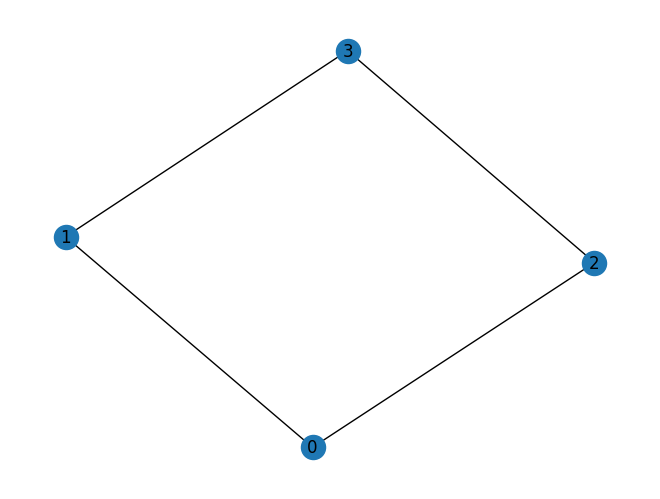

In [25]:
import networkx as nx

N_points = 4
G = nx.random_regular_graph(d=2, n=N_points, seed=999)
pos = nx.spring_layout(G, seed=444)
nx.draw(G, with_labels=True, pos=pos)

## Solving MaxCut using QAOA and IQM Garnet on Braket

At the heart of the Quantum Approximate Optimization Algorithm (QAOA) is a parametrized quantum circuit designed to tackle complex optimization problems, like the Max Cut problem. The QAOA circuit is designed to efficiently explore the solution space of a given problem. It is composed of a series of alternating layers of single-qubit rotations and two-qubit interactions. By adjusting the parameters in the circuit, QAOA aims to find the optimal configuration that maximizes or minimizes a specific objective function, such as the MaxCut value in a given graph.

QAOA operates by encoding the problem into a **problem hamiltonian** whose ground state represents the optimal solution. The dynamics of the problem hamiltonian are encoded in a quantum computer by a circuit representing the **problem unitary**. Correspondingly, a circuit representing the so-called **mixer unitary** is used to explore more possible solutions to the problem. By alternating between the application of the problem unitary and the mixer unitary, QAOA evolves the quantum system toward the ground state of the problem Hamiltonian, which corresponds to the optimal solution of the combinatorial problem. 

In [26]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.circuit import Parameter
from iqm.qiskit_iqm import IQMCircuit

no_qubits = N_points
# Create Quantum Registers and Quantum Circuit
q = QuantumRegister(no_qubits, 'q') # qubits 
c = ClassicalRegister(no_qubits, 'c') # used for readout

def create_problem_circuit(parameter, graph):
    """
    Creates a problem circuit that is part of the QAOA ansatz.
    """
    qc = IQMCircuit(q, c)
    for pair in list(graph.edges()):  # pairs of nodes
        qc.rzz(2 * parameter, pair[0], pair[1]) 
    return qc


gamma = Parameter("$\\gamma$")
circ_prob = create_problem_circuit(gamma, G)

def create_mixer_circuit(parameter):
    """
    Creates a mixer circuit that is part of the QAOA ansatz.
    """
    qc = IQMCircuit(q, c)
    for qubit in q:
        qc.rx(2 * parameter, qubit)
    return qc

beta = Parameter("$\\beta$")
circ_mixer = create_mixer_circuit(beta)

circ_qaoa = QuantumCircuit(q, c)
# First, we define the initial state preparation step
for qubit in q:
    circ_qaoa.h(qubit)

# Then we combine the previous circuits using the compose() method:
circ_qaoa = circ_qaoa.compose(circ_prob).compose(circ_mixer)
circ_qaoa.barrier()
delta = Parameter("$\\delta$")
epsilon = Parameter("$\\epsilon$")
circ_mixer_layer_2 = create_mixer_circuit(delta)
circ_prob_layer_2 = create_problem_circuit(epsilon, G)
circ_qaoa = circ_qaoa.compose(circ_prob_layer_2).compose(circ_mixer_layer_2)
circ_qaoa.barrier()
circ_qaoa.measure(q,c)
circ_qaoa.draw()

┌───┐                                                                    »
q_0: ┤ H ├──────────────────■─────────────────────────────────■───────────────»
     ├───┤                  │                                 │ZZ(2*$\gamma$) »
q_1: ┤ H ├──────────────────┼────────────────■────────────────■───────────────»
     ├───┤                  │ZZ(2*$\gamma$)  │               ┌───────────────┐»
q_2: ┤ H ├─■────────────────■────────────────┼───────────────┤ Rx(2*$\beta$) ├»
     ├───┤ │ZZ(2*$\gamma$)                   │ZZ(2*$\gamma$) ├───────────────┤»
q_3: ┤ H ├─■─────────────────────────────────■───────────────┤ Rx(2*$\beta$) ├»
     └───┘                                                   └───────────────┘»
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌───────────────┐ ░                                       »
«q_0: ┤ Rx(2*$\beta$) ├─░─────────────────────■─────────────────»
«     ├───────────────┤ ░                     │                 »
«q_1: ┤ Rx(2*$\beta$) ├─░─────────────────────┼─────────────────»
«     └───────────────┘ ░                     │ZZ(2*$\epsilon$) »
«q_2: ──────────────────░──■──────────────────■─────────────────»
«                       ░  │ZZ(2*$\epsilon$)                    »
«q_3: ──────────────────░──■────────────────────────────────────»
«                       ░                                       »
«c: 4/══════════════════════════════════════════════════════════»
«                                                               »
«                                           ┌────────────────┐ ░ ┌─┐         
«q_0: ────────────────────■─────────────────┤ Rx(2*$\delta$) ├─░─┤M├─────────
«                         │ZZ(2*$\epsilon$) ├────────────────┤ ░ └╥┘┌─┐      
«q_1: ─■──────────────────■─────────────────┤ Rx(2*$\delta$) ├─░──╫─┤M├──────
«      │                  ┌────────────────┐└────────────────┘ ░  ║ └╥┘┌─┐   
«q_2: ─┼──────────────────┤ Rx(2*$\delta$) ├───────────────────░──╫──╫─┤M├───
«      │ZZ(2*$\epsilon$)  ├────────────────┤                   ░  ║  ║ └╥┘┌─┐
«q_3: ─■──────────────────┤ Rx(2*$\delta$) ├───────────────────░──╫──╫──╫─┤M├
«                         └────────────────┘                   ░  ║  ║  ║ └╥┘
«c: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                 0  1  2  3

## Evaluating possible solutions to the MaxCut problem

In order to find the best parameters $\gamma$ and $\beta$, we need to have a way that measures how "good" a solution is. This is done with the cost function. It maps each possible solution (typically a bitstring like `0100`) to a real number, typically representing the cost or energy associated with that solution. Lower values of the cost function correspond to more optimal or favorable solutions.

An easy way to do this for MaxCut is to count how many edges we cut. The more edges the better. As we want to have the optimal solution corresponding to the minimal cost, we can just multiply the number of cuts with -1, so the optimal solution maps to the lowest number.



<div style="color: #55595f;    background-color: white; margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);">
Note that we cannot use IQMs backend functions (qiskit_iqm) here since we need to use the Braket backend. Amazon and IQM are working on providing more functionality here however.
</div>

In [27]:
from qiskit.compiler import transpile

transpiled_circ_qaoa = transpile(circ_qaoa, backend=backend)

def cost_function(graph, solution):
    """
    Compute the count of all edges of graph that are cut given a possible solution
    """
    solution_reverse = solution[::-1]
    cut = 0
    for i, j in list(graph.edges()):
        if solution_reverse[i] != solution_reverse[j]:
            cut += 1
    return -1 * cut

def compute_expectation_value(graph, counts): 
    """
    Computes expectation value based on measurement results
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = cost_function(graph, bitstring)
        avg += obj * count
        sum_count += count

    return avg/sum_count


def create_objective_function(graph, circuit):
    """
    Creates a function that maps the parameters to the parametrized circuit, 
    runs it and computes the expectation value
    """
    def objective_function(theta):

        job = backend.run(circuit.assign_parameters(theta), shots=10)
        result=job.result()
        counts=result.get_counts()        
        return compute_expectation_value(graph, counts)

    return objective_function

The QAOA algorithm is then facilitated by a classical optimization loop that is minimizing the expectation value of the problem hamiltonian. Thus, helping us getting closer to its ground state.


In [28]:
from scipy.optimize import minimize

expectation = create_objective_function(G, transpiled_circ_qaoa)

result = minimize(expectation,
                      [1.0, -1.0, 1.0, -1.0],
                      method='COBYLA',
                      options={'maxiter':10}
                 )
result

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -3.0
       x: [ 2.000e+00 -1.000e+00  1.000e+00 -1.000e+00]
    nfev: 10
   maxcv: 0.0

Of course, it's possible to keep the results of the last execution and directly use that to solve our MaxCut problem. However, for clarity and learning purposes, we will use the optimized parameters we acquired through the classical loop to run the quantum circuit one more time.

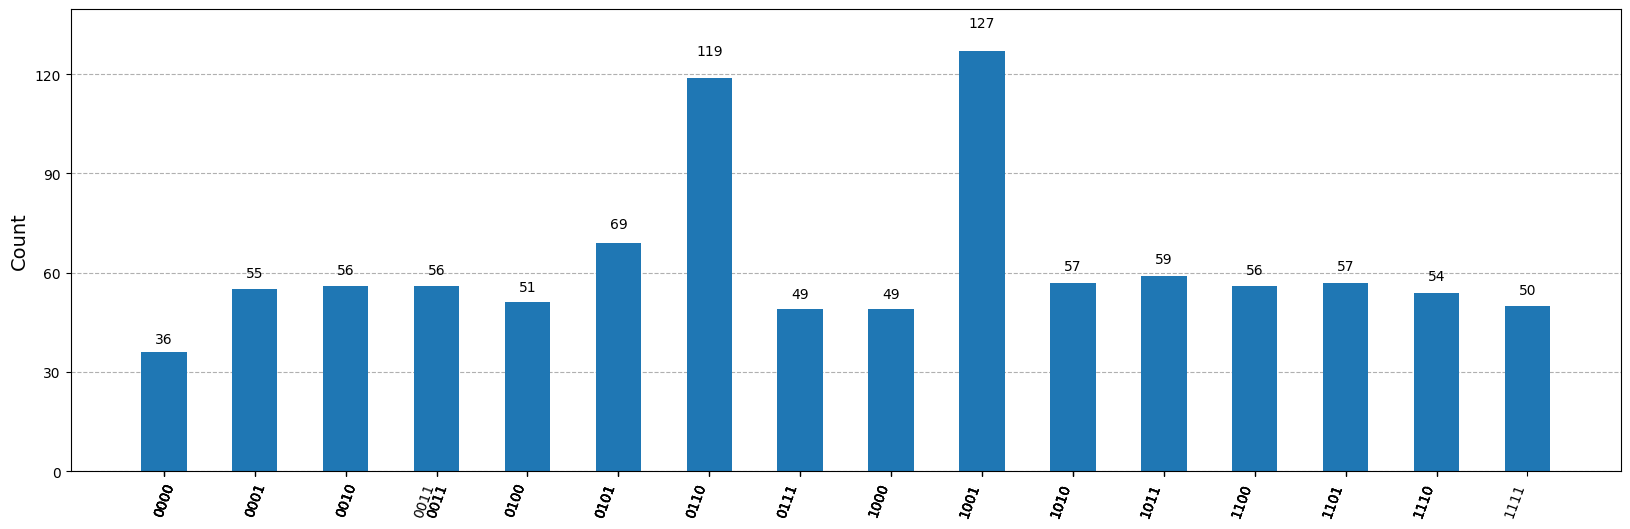

In [29]:
# Execute the circuit with the optimized parameters
optimized_parameters = result.x
counts = backend.run(transpiled_circ_qaoa.assign_parameters(optimized_parameters), shots=1000).result().get_counts()

# Plot the results
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

After running the algorithm, we can look into the results. 

The top three results are  [('1001', 127), ('0110', 119), ('0101', 69)]
The maximum cut is given by 0110 with a cut length of 4


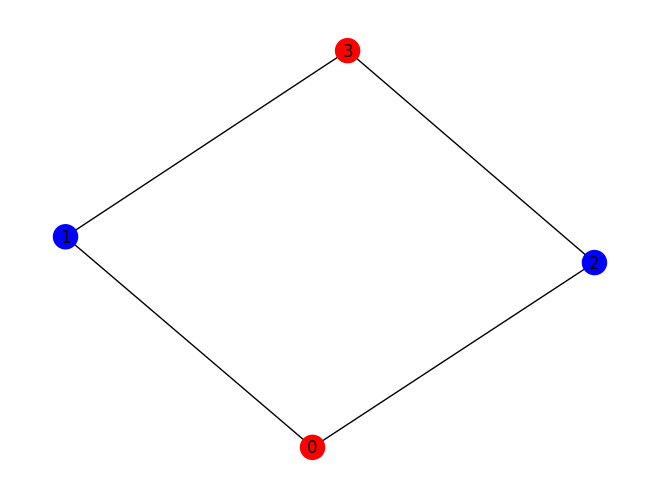

In [31]:
# Sort the counts by their values in descending order
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Get the top three results
top_three_results = sorted_counts[:3]

print("The top three results are ",  top_three_results)
results=[]
for res in top_three_results:
    results.append([cost_function(G,res[0]),res[0]])

# Get the best solution given the results of the maxcut objective function
max_cut_length, max_cut = min(results) 
print("The maximum cut is given by " + max_cut + " with a cut length of " + str(-max_cut_length))



from qiskit_optimization.applications import Maxcut

solution_aux = [int(x) for x in max_cut]
solution = solution_aux[::-1]
plt.figure()
pos = nx.spring_layout(G, seed=444)
Maxcut(G).draw(result=np.array(solution), pos=pos)
plt.show()

Of course, this is not the only way to solve the MaxCut problem. There are other methods or QAOA variants to solve this problem. So just see this notebook as a starting point on how to get your qiskit experiments running on IQM Garnet using Amazon Braket.

In [ ]:

# Copyright 2024 IQM Quantum Computers (Max Haeberlein, Jalil Khatibi Moqadam, Stefan Seegerer, Hermanni Heimonen)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.